In [1]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad1d, FlattenN, Reshape, ExpandN, SqueezeT
from cosmosis.dataset import SqueezeN, Index, EmbedLookup, AsSparse, AsTensor
from cosmosis.learning import Selector, Metrics

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import GraphNet, PygModel, EncoderLoss, GraphNetVariationalEncoder
from learning import Learn

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T


In [2]:
# qchem dataset (QM9) with PyG Data output
# extract, filter, save, transform, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','bond_type','bond_stereo','bond_conjugated','bond_ring']

lookup = QM9.embed_lookup

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'bond_type': ['bond_type'],
                                            'bond_ring': ['bond_ring'],
                                            'hybridization': ['hybridization'],
                                            'chirality': ['chirality'],
                                            'coulomb': ['coulomb'],
                                            'distance': ['distance'],
                                            'adjacency': ['adjacency'],
                                            'mulliken': ['mulliken'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [EmbedLookup(lookup['hybridization']), 
                                                               AsTensor()],
                                             'chirality': [EmbedLookup(lookup['chirality']), 
                                                           AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'bond_type': [AsTensor()],
                                             'bond_stereo': [AsTensor()],
                                             'bond_conjugated': [AsTensor()],
                                             'bond_ring': [ExpandN(1), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [ExpandN(1), AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','>','8'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'test.pkl', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])
k = qm9.ds_idx[0]
molecule = qm9[k]
print('molecule: ', molecule)
qm9.ds[k].rdmol
print('molecule.x: \n', molecule.x)
print('molecule.edge_attr: \n', molecule.bond_ring)
print('molecule.edge_index: \n', molecule.edge_index)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  975
CDataset created...
QDataset created...
molecule:  Data(x=[5, 3], edge_index=[2, 8], y=[1, 1], idx=1, bond_type=[8], bond_ring=[8, 1], hybridization=[5], chirality=[5], coulomb=[5, 5], distance=[5, 5], adjacency=[5, 5], mulliken=[5, 1])
molecule.x: 
 tensor([[6., 0., 4.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.]])
molecule.edge_attr: 
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
molecule.edge_index: 
 tensor([[0, 1, 1, 0, 0, 2, 2, 0],
        [0, 3, 3, 0, 0, 4, 4, 0]])


In [3]:
# exploring qchem dataset (QM9) 

l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['mulliken'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]


longest molecule index:  228  length:  20
shortest molecule index:  3  length:  3


Data(x=[3, 3], edge_index=[2, 4], y=[1, 1], idx=3, bond_type=[4], bond_ring=[4, 1], hybridization=[3], chirality=[3], coulomb=[3, 3], distance=[3, 3], adjacency=[3, 3], mulliken=[3, 1])

shortest molecule


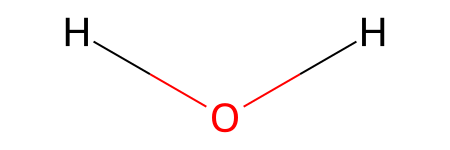

In [4]:
# display qchem dataset (QM9)

print('shortest molecule')
qm9.ds[si].rdmol

longest molecule


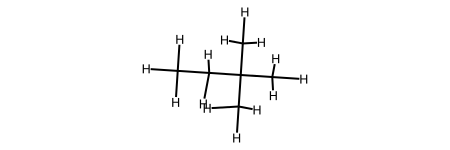

In [5]:
# display qchem dataset (QM9)

print('longest molecule')
qm9.ds[li].rdmol

In [6]:
# qchem dataset (QM9) batch and loader mechanism with PyG Data output
# augmented with rdkit mol data (2.7 GB, 133,885 molecules)
# the preprocessing can be greedy or thrifty to optimize speed or memory
# extract, filter, save, transform, load, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup = QM9.embed_lookup
                                          
ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'bond_type': ['bond_type'],
                                            'bond_ring': ['bond_ring'],
                                            'hybridization': ['hybridization'],
                                            'chirality': ['chirality'],
                                            #'coulomb': ['coulomb'],
                                            #'distance': ['distance'],
                                            #'adjacency': ['adjacency'],
                                            #'mulliken': ['mulliken'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [EmbedLookup(lookup['hybridization']), 
                                                               AsTensor()],
                                             'chirality': [EmbedLookup(lookup['chirality']), 
                                                           AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'bond_type': [AsTensor()],
                                             'bond_stereo': [AsTensor()],
                                             'bond_conjugated': [AsTensor()],
                                             'bond_ring': [ExpandN(1), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [ExpandN(1), AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','>','8'), 
                              'n': 1000, #non-random subset for testing,
                              #'use_pickle': 'test.pkl', #use pickle if exists otherwise create
                              'n_conformers': 2,
                              'dict2data': True}}

qm9 = QM9(**ds_param['train_param'])

ds_idx = qm9.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(qm9, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', qm9[1])
print('pgds[1].x: ', qm9[1].x)
print('pgds[1].y: ', qm9[1].y)
print('pgds[1].idx: ', qm9[1].idx)
print('pgds[1].edge_index: ', qm9[1].edge_index)
print('pgds[1].edge_attr: ', qm9[1].bond_type)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  975
CDataset created...
QDataset created...
batch:  DataBatch(x=[25, 3], edge_index=[2, 50], y=[2, 1], idx=[2], bond_type=[50], bond_ring=[50, 1], hybridization=[25], chirality=[25], batch=[25], ptr=[3])
batch.ptr:  tensor([ 0, 11, 25])
batch.idx:  tensor([890, 839])
batch.x:  tensor([[7., 0., 3.],
        [6., 1., 3.],
        [6., 1., 3.],
        [7., 1., 3.],
        [6., 1., 3.],
        [8., 0., 1.],
        [8., 1., 2.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [6., 0., 4.],
        [6., 1., 3.],
        [6., 1., 3.],
        [7., 1., 3.],
        [6., 1., 3.],
        [8., 0., 2.],
        [6., 1., 3.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
        [1., 0., 1.],
     

In [7]:
# PyG dataset wrapper (PGDS) with PyG Data output

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])


In [8]:
# PyG dataset wrapper (PGDS) with dictionary output

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'input_dict': {'x': ['x'],
                                           'y': ['y']},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

pgds = PGDS(**ds_param['train_param'])
print(pgds[0])

creating pytorch geometric QM9 dataset...
CDataset created...
{'x': tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), 'y': tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
           -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
           157.7070]])}


In [9]:
# PyG dataset wrapper (PGDS) batch and loader mechanism
# extract, transform, load, display

import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_param = {'train_param': {'dataset': 'QM9',
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': IndexY(7)}}}

pgds = PGDS(**ds_param['train_param'])
ds_idx = pgds.ds_idx
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)
print('pgds[1].edge_index: ', pgds[1].edge_index)
print('pgds[1].edge_attr: ', pgds[1].edge_attr)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[32, 11], edge_index=[2, 66], edge_attr=[66, 4], y=[2], pos=[32, 3], z=[32], smiles=[2], name=[2], idx=[2], batch=[32], ptr=[3])
batch.ptr:  tensor([ 0, 18, 32])
batch.idx:  tensor([ 65972, 132642])
batch.x:  tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  10000
total uncharacterized molecules removed:  273
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9727
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  52008961
running model on gpu...

........final........

total learning time: 0:00:35.573503
test loss: 13.129039764404297


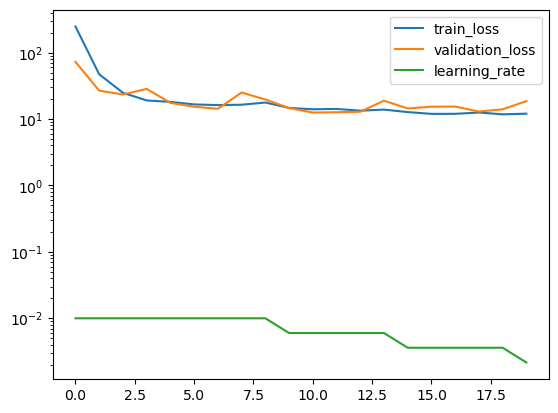

In [3]:
# qchem dataset (QM9) with comosis model (FFNet)
# extract, filter, transform, embed, save, load, model, metrics, display


qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup_hybrid = QM9.embed_lookup['hybridization']
lookup_chiral = QM9.embed_lookup['chirality']
# cosmosis uses 'X' and 'y' while pyg uses 'x' and 'y'

ds_param = {'train_param': {'input_dict': {'X': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                 'mulliken',
                                                 'coulomb',
                                                  ],
                                             #'idx': ['idx'],
                                             #'edge_index': ['edge_indices'],
                                             #'edge_attr': ['edge_attr'],
                                             #'coulomb': ['coulomb'],
                                             #'distance': ['distance'],
                                             #'adjacency': ['adjacency'],
                                             #'mulliken': ['mulliken'],
                                             'hybridization': ['hybridization'],
                                             'chirality': ['chirality'],
                                             'y': ['U0']},
                              'transforms': {
                                             'hybridization': [Pad1d(29), EmbedLookup(lookup_hybrid), AsTensor()],
                                             'chirality': [Pad1d(29), EmbedLookup(lookup_chiral), AsTensor()],
                                             'atomic_number': [Pad1d(29), AsTensor()],
                                             'aromatic': [Pad1d(29), AsTensor()],
                                             'degree': [Pad1d(29), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [Pad1d(29), AsTensor()],
                                             'coulomb': [FlattenN(), Pad1d(29*29), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','>','8'), 
                              'n': 10000, #non-random subset for testing,
                              #'use_pickle': 'qm9_10', #use pickle if exists otherwise create
                              'n_conformers': 10,
                              'dict2data': False}}

model_param = {'in_channels': 29+29+29+29+29*29+29*8+29*8,
               'hidden': 4096, 
               'out_channels': 1, 
               'model_name': 'funnel',
               'embed_param': {
                               'hybridization': (9,8,0,True),
                               'chirality': (4,8,0,True),
                               'flatten': True,
                               'start_dim': 1
                               }
              }

metrics_param = {'report_interval': 60,
                 'log_plot': True,
                 'min_lr': .0013} #early stopping when lr is =<

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                #'subset': .1, #create random subset
                }

sched_param = {'factor': .6,
               'patience': 2,
               'cooldown': 2} 

opt_param = {'lr': 0.01}


l = Learn([QM9], 
          FFNet,
          Metrics=Metrics,
          Sampler=Selector, 
          Optimizer=Adam, 
          Scheduler=ReduceLROnPlateau, 
          Criterion=L1Loss,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=512, epochs=20, save_model=False)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
GraphNet NetConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  132097
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
running model on gpu...

.....................

total elapsed time: 0:00:30.470335
epoch: 1
y_pred last 10:  tensor([[-1421.4460],
        [-1981.2582],
        [-1989.9728],
        [ -887.6658],
        [-1984.4109],
        [-2345.4856],
        [-1917.6976],
        [-2077.7739],
        [ -863.8814],
        [-1781.0648]], device='cuda:0')
y last 10:  tensor([[-12991.5586],
        [-10936.3340],
        [-10902.0332],
        [-11373.2461],
        [ -9429.6738],
        [-11947.9805],
        [-10433.4785],
        [-13008.0723],
        [-11542.8730],
        [ -9396.2158]], device='cuda:0')


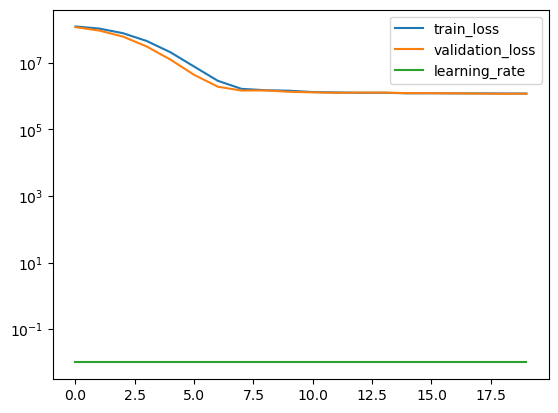

In [3]:
# PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# NetConv convolutions with edge features
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'in_channels': 11, 
               'hidden': 128, 
               'out_channels': 64,
               'depth': 2,
               'convolution': 'NetConv', # uses edge features
               'pooling': 'global_mean_pool',
               'conv_act': 'ReLU',
               'dropout': .3,
               'activation': 'ReLU',
               'edge_attr': ['edge_attr'],
               'data_keys': ['x'],
               'layer_param': {'edge_features': 4},
               'ffn_param': {'in_channels': 64,
                             'hidden': 128,
                             'out_channels': 1}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
               # 'subset': .1,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=512, epochs=20)

# cosmosis qm9 feature U0 is in hartree while pyg qm9 U0 (y[7]) is in eV 
# hartree * 27.2114 = eV

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
GraphNet SAGEConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  94081
running model on gpu...

.....................

total elapsed time: 0:00:34.332157
epoch: 4
y_pred last 10:  tensor([[-8921.4736],
        [-6716.4395],
        [-8279.2246],
        [-8932.0283],
        [-7837.6797],
        [-7616.6006],
        [-8481.0879],
        [-8454.2002],
        [-8292.8838],
        [-7960.0449]], device='cuda:0')
y last 10:  tensor([[-12788.3906],
        [-10901.1748],
        [-11843.6953],
        [-11342.2676],
        [-10500.7627],
        [-10904.4170],
        [-11284.8848],
        [-10499.6641],
        [-12553.8213],
        [-11575.6865]], device='cuda:0')
train loss: 19780277.5, val loss: 12157053.657894736
lr: 0.01

.....................

total elapsed time:

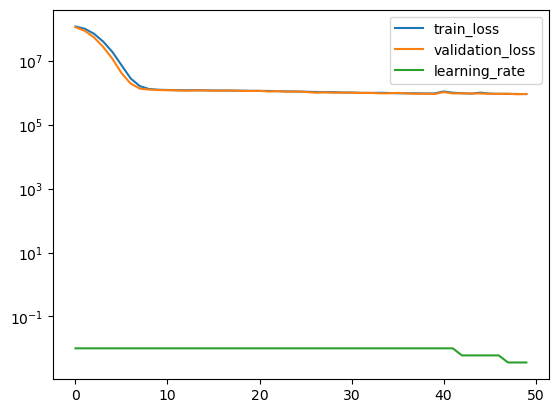

In [2]:
# PyG dataset wrapper (PGDS) with qchem model (GraphNet)
# SAGEConv convolutions
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'in_channels': 11, 
               'hidden': 256, 
               'out_channels': 64,
               'depth': 2,
               'convolution': 'SAGEConv',
               'pooling': 'global_mean_pool',
               'conv_act': 'ReLU',
               'dropout': .3,
               'activation': 'ReLU',
               'layer_param': {},
               'ffn_param': {'in_channels': 64,
                             'hidden': 128,
                             'out_channels': 1}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0013}

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'subset': None,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 2,
               'cooldown': 2,
               'min_lr': .00125}


l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=512, epochs=50)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  10000
total uncharacterized molecules removed:  273
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9727
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
GraphNet NetConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  536833
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
running model on gpu...

........final........

total learning time: 0:00:11.960303
test loss: 30484.36328125


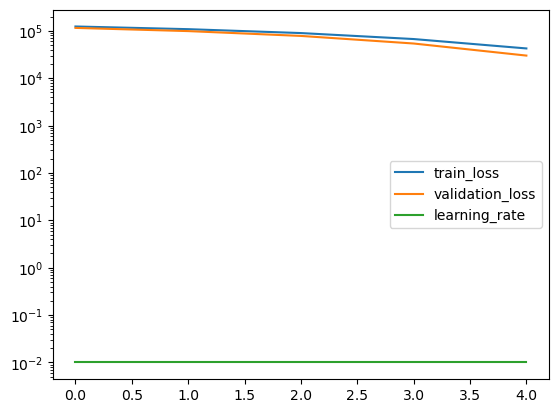

In [4]:
# qchem dataset (QM9) with qchem model (GraphNet)
# extract, filter, transform, embed, save, load, model, metrics, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup = QM9.embed_lookup

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            'bond_type': ['bond_type'],
                                            'bond_ring': ['bond_ring'],
                                            'bond_stereo': ['bond_stereo'],
                                            'bond_conjugated': ['bond_conjugated'],
                                            'hybridization': ['hybridization'],
                                            'chirality': ['chirality'],
                                            #'coulomb': ['coulomb'],
                                            #'distance': ['distance'],
                                            #'adjacency': ['adjacency'],
                                            #'mulliken': ['mulliken'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [EmbedLookup(lookup['hybridization']), 
                                                               AsTensor()],
                                             'chirality': [EmbedLookup(lookup['chirality']), 
                                                           AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'bond_type': [AsTensor()],
                                             'bond_stereo': [AsTensor()],
                                             'bond_conjugated': [ExpandN(1), AsTensor()],
                                             'bond_ring': [ExpandN(1), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [ExpandN(1), AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','>','8'), 
                              'n': 10000, #non-random subset for testing,
                              #'use_pickle': 'qm9_10', #use pickle if exists otherwise create
                              'n_conformers': 0,
                              'dict2data': True}}

model_param = {'in_channels': 16+16+1+1+1, 
               'hidden': 128, 
               'out_channels': 64,
               'depth': 2,
               'convolution': 'NetConv', # uses edge features
               'pooling': 'global_mean_pool',
               'conv_act': 'ReLU',
               'dropout': .3,
               'activation': 'ReLU',
               'edge_attr': ['bond_type','bond_ring','bond_stereo','bond_conjugated'],
               'data_keys': ['x','hybridization','chirality'],
               'embed_param': {
                               'hybridization': (9,16,None,True),
                               'chirality': (5,16,None,True),
                               'bond_type': (6,16,None,True),
                               'bond_stereo': (7,16,None,True),
                               },
               'layer_param': {'edge_features': 16+1+16+1},
               'ffn_param': {'in_channels': 64,
                             'hidden': 128,
                             'out_channels': 1}}

metrics_param = {'report_interval': 60,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                #'subset': .1
               }

sched_param = {'factor': .6,
               'patience': 2,
               'cooldown': 2}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=20, num_workers=4,
          load_embed=False, save_model=False, load_model=None)

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  10000
total uncharacterized molecules removed:  273
total molecules removed for insuffient rdmol conformations:  0
total molecules created:  9727
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
GraphNet SAGEConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  106369
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  54849
running model on gpu...

........final........

total learning time: 0:00:07.324837
test loss: 36459.8453125


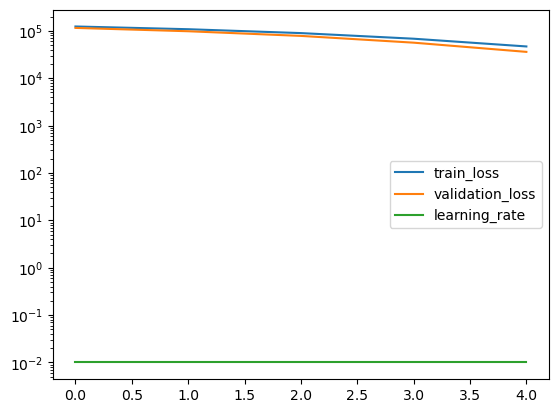

In [5]:
# qchem dataset (QM9) with qchem model (GraphNet)
# extract, filter, transform, embed, save, load, model, metrics, display

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

rdkit_features = ['atom_type','atomic_number','aromatic','chirality',
                  'degree','charge','n_hs','n_rads','hybridization',
                  'edge_indices','edge_attr','rdmol_block','n_atoms',
                  'xyz','distance','coulomb','adjacency','rdmol']

rdkit_edge = ['edge_indices','edge_attr']

lookup = QM9.embed_lookup

ds_param = {'train_param': {'input_dict': {'x': [
                                                 'atomic_number',
                                                 'aromatic',
                                                 'degree',
                                                  ],
                                            'idx': ['idx'],
                                            'edge_index': ['edge_indices'],
                                            #'bond_type': ['bond_type'],
                                            #'bond_ring': ['bond_ring'],
                                            'hybridization': ['hybridization'],
                                            'chirality': ['chirality'],
                                            #'coulomb': ['coulomb'],
                                            #'distance': ['distance'],
                                            #'adjacency': ['adjacency'],
                                            #'mulliken': ['mulliken'],
                                            'y': ['U0']},
                              'transforms': {
                                             'hybridization': [EmbedLookup(lookup['hybridization']), 
                                                               AsTensor()],
                                             'chirality': [EmbedLookup(lookup['chirality']), 
                                                           AsTensor()],
                                             'atomic_number': [ExpandN(1), AsTensor()],
                                             'aromatic': [ExpandN(1), AsTensor()],
                                             'degree': [ExpandN(1), AsTensor()],
                                             'edge_indices': [AsTensor()],
                                             'mulliken': [ExpandN(1), AsTensor()],
                                             'coulomb': [AsTensor()],
                                             'bond_type': [AsTensor()],
                                             'bond_stereo': [AsTensor()],
                                             'bond_conjugated': [AsTensor()],
                                             'bond_ring': [ExpandN(1), AsTensor()],
                                             'distance': [],
                                             'adjacency': [],
                                             'idx': [AsTensor()],
                                             'U0': [ExpandN(1), AsTensor()],
                                            },
                              #'filter_on': ('n_atoms','>','8'), 
                              'n': 10000, #non-random subset for testing,
                              #'use_pickle': 'qm9_10', #use pickle if exists otherwise create
                              'n_conformers': 10,
                              'dict2data': True}}


model_param = {'in_channels': 3+16+16, 
               'hidden': 256, 
               'out_channels': 64,
               'depth': 2,
               'convolution': 'SAGEConv',
               'pooling': 'global_mean_pool',
               'conv_act': 'ReLU',
               'dropout': .3,
               'activation': 'ReLU',
               'edge_attr': [],
               'data_keys': ['x','hybridization','chirality'],
               'layer_param': {},
               'embed_param': {
                               'hybridization': (9,16,None,True),
                               'chirality': (5,16,None,True),
                               },
               'ffn_param': {'in_channels': 64,
                             'hidden': 128,
                             'out_channels': 1}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 3,
               'cooldown': 3}


l = Learn([QM9], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=5, save_model=False, load_model=None)

In [6]:
# PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITHOUT adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

hidden = 128

model_param = {'in_channels': 11, 
               'hidden': hidden, 
               'out_channels': hidden,
               'depth': 2,
               'pooling': None,
               'ffn_param': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0013,
                 'metric_name': 'roc_auc_score',
                 'metric_param': {}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': False,
              'disc_param': None}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': None}

sched_param = {'factor': .6,
               'patience': 2,
               'cooldown': 1}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, batch_size=256, epochs=20, target=None, num_workers=4)

creating pytorch geometric QM9 dataset...
CDataset created...
GraphNet GCNConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  18304
GraphNetVariationalEncoder loaded...
default weight initialization...
GraphNetVariationalEncoder model loaded...
number of model parameters:  51328
running model on gpu...

.....................

total elapsed time: 0:01:17.854701
epoch: 0
y_pred last 10:  tensor([0.3697, 0.4282, 0.3879, 0.4801, 0.1179, 0.3107, 0.6354, 0.7140, 0.2723,
        0.1327], device='cuda:0')
y last 10:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
train loss: 0.19650274035142584, val loss: 0.051568548832284775
lr: 0.01
roc_auc_score train score: 0.6998162056109142, validation score: 0.7513352243000703

.....................

total elapsed time: 0:02:33.883244
epoch: 1
y_pred last 10:  tensor([0.4098, 0.5178, 0.9366, 0.5658, 0.5759, 0.5099, 0.6095, 0.5099, 0.4881,
        0.3194], device='cuda:0')
y last 10:  t

KeyboardInterrupt: 

creating pytorch geometric QM9 dataset...
CDataset created...
GraphNet GCNConv loaded...
default weight initialization...
GraphNet model loaded...
number of model parameters:  18304
GraphNetVariationalEncoder loaded...
default weight initialization...
GraphNetVariationalEncoder model loaded...
number of model parameters:  51328
running model on gpu...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  71296

.....................

total elapsed time: 0:01:28.875751
epoch: 0
y_pred last 10:  tensor([0.4925, 0.4869, 0.5204, 0.3362, 0.6673, 0.5481, 0.7106, 0.5280, 0.6470,
        0.5735], device='cuda:0')
y last 10:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
train loss: 0.21384832379864713, val loss: 0.07209954410791397
lr: 0.01
roc_auc_score train score: 0.702359564013689, validation score: 0.7611841775862892

.....................

total elapsed time: 0:02:57.974473
epoch: 1
y_pred last 10:  tensor([0.7995, 0.6898, 

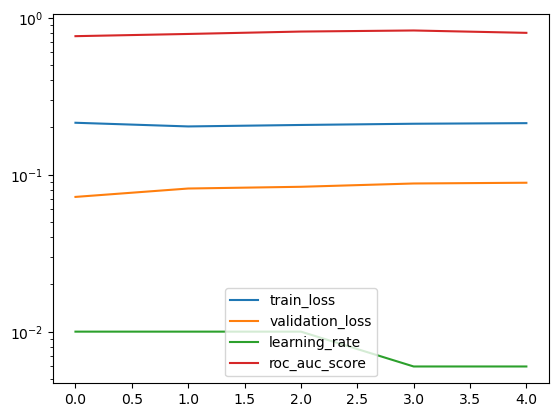

In [2]:
# PyG dataset wrapper (PGDS) with qchem model (GraphNetVariationalEncoder)
# graph variational autoencoder WITH adversarial regulation and GCNConv encoder
# extract, load, model, metrics, display

hidden = 128

model_param = {'in_channels': 11, 
               'hidden': hidden, 
               'out_channels': hidden,
               'depth': 2,
               'pooling': None,
               'convolution': 'GCNConv'}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': None}}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0035,
                 'metric_name': 'roc_auc_score',
                 'metric_param': {}}

opt_param = {'lr': 0.01}

crit_param = {'adversarial': True,
              'disc_param': {'in_channels': hidden, 
                             'hidden': hidden, 
                             'out_channels': hidden}}

sample_param = {'set_seed': 88,
                'splits': (.7, .15),
                'subset': None}

sched_param = {'factor': .6,
               'patience': 2,
               'cooldown': 2}


l = Learn([PGDS], GraphNetVariationalEncoder, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=EncoderLoss, DataLoader=DataLoader,
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=256, epochs=5, num_workers=4)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  858369
pytorch geometric model GraphSAGE loaded...
running model on gpu...

.....................

total elapsed time: 0:00:10.904154
epoch: 0
y_pred last 10:  tensor([[-6050.6885],
        [-1725.8054],
        [-7560.7456],
        [-7800.0879],
        [-6496.3311],
        [-6282.1841],
        [-5602.5630],
        [-2173.7791],
        [-5591.8984],
        [-6096.3721]], device='cuda:0')
y last 10:  tensor([[ -9836.1602],
        [-10564.9307],
        [-13007.0645],
        [-12320.7354],
        [-10337.3018],
        [-11485.3135],
        [-10801.4697],
        [ -7851.9238],
        [-10939.5713],
        [-11542.4648]], device='cuda:0')
train loss: 88177562.08403361, val loss: 32368968.55263158
lr: 0.01

.....................

total elapsed time: 0:00:21.644787
epoch: 1
y_pred last 10:  tensor([[-11320.1104],
     

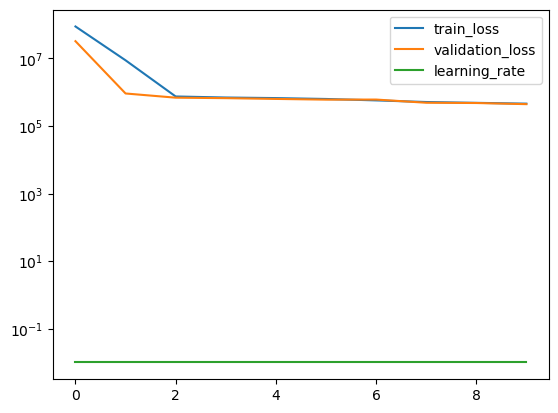

In [2]:
# PyG dataset wrapper (PGDS) with PyG model wrapper (PygModel)
# extract, transform, load, model, metrics, display

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y.unsqueeze(0)
        return data

model_param = {'model_name': 'GraphSAGE',
               'pooling': 'global_mean_pool',
               'ffn_param': {'in_channels': 256,
                             'hidden': 512,
                             'out_channels': 1,
                             'dropout': .3,
                             'activation': 'ReLU'},
               'pyg_param': {'in_channels': 11, # GraphSAGE param
                             'hidden_channels': 256,
                             'num_layers': 2,
                             'out_channels': 256,
                             'dropout': .1,
                             'norm': 'BatchNorm'}}

ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {},
                            'pg_param': {'root': './data/pyg/qm9/',
                                         'transform': T.Compose([IndexY(7)])}}}

metrics_param = {'report_interval': 30,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5}

learn = Learn([PGDS], 
              PygModel,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=MSELoss,
              DataLoader=DataLoader,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=256, epochs=10, gpu=True)


creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  12213249
running model on gpu...

.....................

total elapsed time: 0:01:01.437083
epoch: 40
y_pred last 10:  tensor([[-12118.3984],
        [-10959.6611],
        [ -9833.1133],
        [-11527.5176],
        [-10577.6133],
        [-12150.0918],
        [-11774.2227],
        [-11674.7188],
        [-12237.4541],
        [-11147.0410]], device='cuda:0')
y last 10:  tensor([[-12351.7900],
        [-10934.9951],
        [ -9396.2461],
        [-11510.1113],
        [-10566.4395],
        [-11947.4424],
        [-11510.2598],
        [-11981.3389],
        [-12454.9912],
        [-10969.6768]], device='cuda:0')
train loss: 116395.50413602941, val loss: 96465.44791666667
lr: 0.006

........final........

total learning time: 0:01:15.723368
test loss: 155814.61458333334


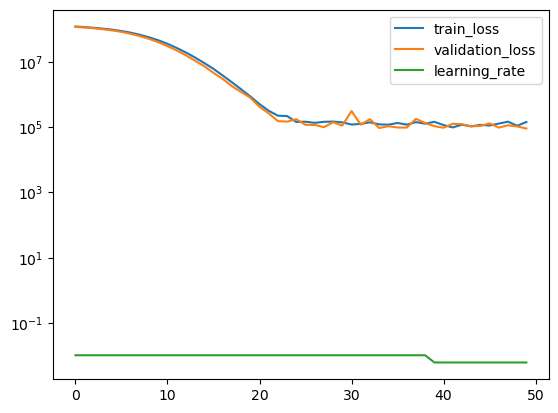

In [2]:
# PyG dataset wrapper (PGDS) with cosmosis model (FFNet)
# dictionary output
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 319, 
               'hidden': 2048, 
               'out_channels': 1,
               'model_name': 'funnel'}
#qchem model keys are 'X' and 'y' while pyg used 'x' and 'y'
ds_param = {'train_param': {'dataset': 'QM9',
                            'transforms': {'y': [Index(7)],
                                           'x': [FlattenN(), Pad1d(29*11)]},
                            'input_dict': {'X': ['x'], 
                                           'y': ['y']},
                            'pg_param': {'root': './data/pyg/qm9/'}}}

metrics_param = {'report_interval': 60,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

opt_param = {'lr': 0.01}

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'subset': .1,
                'splits': (.7, .15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}



l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=512, epochs=50)

CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  12643329
running model on gpu...
early stopping!  learning rate is below the set minimum...

........final........

total learning time: 0:00:11.926552
test loss: 40.062644958496094


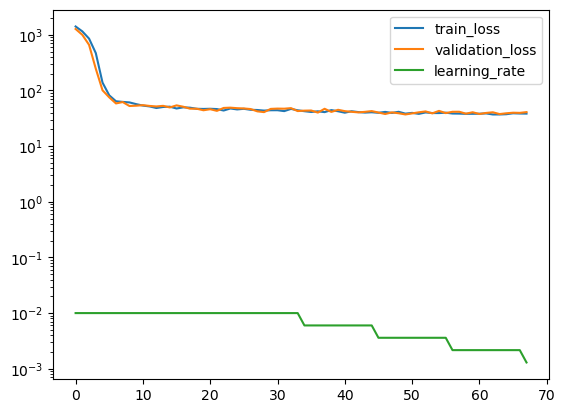

In [3]:
# qchem dataset (QM7) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
               'hidden': 2048, 
               'out_channels': 1, 
               'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['ae']},
                            'in_file': './data/qm7/qm7.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          num_workers=0, batch_size=256, epochs=200)

CDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  12643329
running model on gpu...
early stopping!  learning rate is below the set minimum...

........final........

total learning time: 0:00:12.943565
test loss: 59.90167999267578


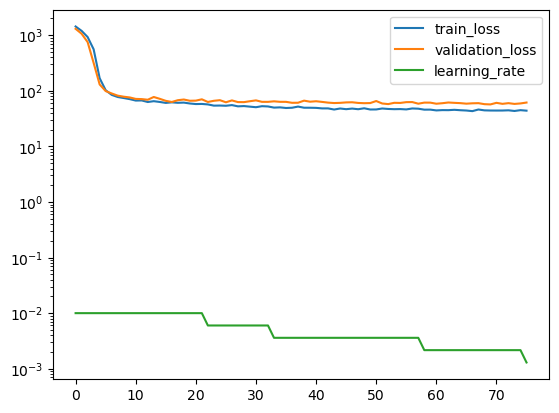

In [4]:
# qchem dataset (QM7b) and cosmosis model (FFNet)
# extract, transform, load, model, metrics, display

model_param = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['E']},
                            'in_file': './data/qm7b/qm7b.mat',
                            'transforms': {'coulomb': [FlattenN()]}}}

metrics_param = {'report_interval': 100,
                  'log_plot': True,
                  'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_param = {'factor': .6,
                'patience': 5,
                'cooldown': 5,
                'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param, 
          batch_size=256, epochs=200, num_workers=0)

In [5]:
# exploring qchem dataset (QM7X)

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_param = {'train_param': {'input_dict': {'X': ['atNUM'],
                                           'y': ['eAT']},
                            'transforms': {},
                            'n': 100, #non-random subset for testing
                            'selector': ['opt']}}

qm7x = QM7X(**ds_param['train_param'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  100
total molecular structures (idconf) mapped:  223
CDataset created...
QDataset created...
longest molecule length:  16  index:  102
(16,)


{'X': array([6., 6., 6., 6., 7., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=float32),
 'y': array([68.552765], dtype=float32)}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  12643329
running model on gpu...

........final........

total learning time: 0:00:01.389514
test loss: 26.982200622558594


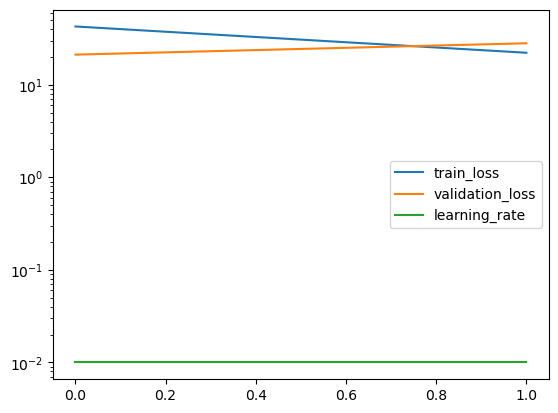

In [6]:
# qchem dataset (QM7X) and cosmosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['eAT']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d(23*23)]},
                            'selector': ['opt'],
                            'n': 1000, #non-random subset for testing
                             }}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}


opt_param = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          metrics_param=metrics_param,
          batch_size=128, epochs=2)

In [7]:
# qchem dataset (ANI1x) with PyG Data output
# extract, filter, transform, display

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': True}}

ani1x = ANI1x(**ds_param['train_param'])
k = ani1x.ds_idx[0]
print(k)
ani1x[k]

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
C10H10


Data(y=[1], X=[3969])

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
QDataset created...
FFNet model loaded...
applying _init_weights...
FFNet model loaded...
number of model parameters:  62445569
running model on gpu...

.....................

total elapsed time: 0:00:11.495613
epoch: 5
y_pred last 10:  tensor([[-877.3489],
        [-329.6523],
        [-482.6555],
        [-612.5309],
        [-432.3997],
        [-489.4329],
        [-613.1198],
        [-525.5873],
        [-309.0716],
        [-529.1799]], device='cuda:0')
y last 10:  tensor([[-876.0524],
        [-382.0550],
        [-530.5383],
        [-616.6958],
        [-444.9136],
        [-478.6259],
        [-609.4036],
        [-536.9368],
        [-337.1994],
        [-543.2257]], device='cuda:0')
train loss: 42.4254830865299, val loss: 33.97993877955845
lr: 0.01

.....................

total elapsed time: 0:00:22.283362
epoch: 11
y_pred last 10:  tensor([[ -479.2721],
    

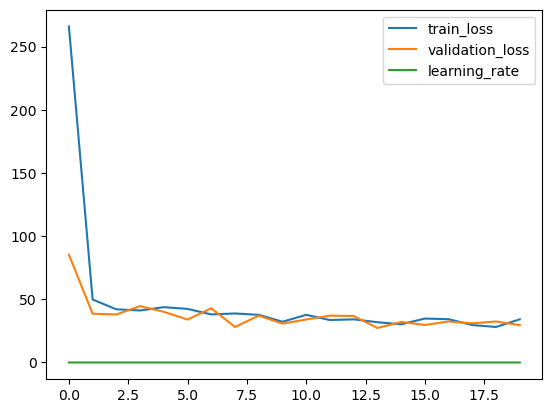

In [8]:
# qchem dataset (ANI1x) and comosis model (FFNet)
# extract, filter, transform, load, model, metrics, display

model_param = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_param = {'train_param': {'input_dict': {'X': ['coulomb'],
                                           'y': ['wb97x_dz.energy']},
                            'transforms': {'coulomb': [FlattenN(), Pad1d((63*63))]},
                            'criterion': ['wb97x_dz.energy'],
                            'conformation': 'max',
                            'in_file': './data/ani1x/ani1x-release.h5',
                            'dict2data': False}}

metrics_param = {'report_interval': 100,
                 'log_plot': True,
                 'min_lr': .0013}  #early stopping

crit_param = {'reduction': 'sum'}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .6,
               'patience': 5,
               'cooldown': 5,
               'min_lr': .00125}

opt_param = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_param=model_param, ds_param=ds_param, sample_param=sample_param,
          opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
          batch_size=64, epochs=20)